In [1]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import sqlite3
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
providers = pd.read_csv("providers_data.csv")
receivers = pd.read_csv("receivers_data.csv")
food_listings = pd.read_csv("food_listings_data.csv")
claims = pd.read_csv("claims_data.csv")

In [4]:
print("Providers dataset shape:", providers.shape)
print("Receivers dataset shape:", receivers.shape)
print("Food Listings dataset shape:", food_listings.shape)
print("Claims dataset shape:", claims.shape)

Providers dataset shape: (1000, 6)
Receivers dataset shape: (1000, 5)
Food Listings dataset shape: (1000, 9)
Claims dataset shape: (1000, 5)


In [5]:
print(providers.isnull().sum())
print(receivers.isnull().sum())
print(food_listings.isnull().sum())
print(claims.isnull().sum())

Provider_ID    0
Name           0
Type           0
Address        0
City           0
Contact        0
dtype: int64
Receiver_ID    0
Name           0
Type           0
City           0
Contact        0
dtype: int64
Food_ID          0
Food_Name        0
Quantity         0
Expiry_Date      0
Provider_ID      0
Provider_Type    0
Location         0
Food_Type        0
Meal_Type        0
dtype: int64
Claim_ID       0
Food_ID        0
Receiver_ID    0
Status         0
Timestamp      0
dtype: int64


In [6]:
providers.drop_duplicates(inplace=True)
receivers.drop_duplicates(inplace=True)
food_listings.drop_duplicates(inplace=True)
claims.drop_duplicates(inplace=True)

In [7]:
conn = sqlite3.connect('food_waste.db')
cursor = conn.cursor()

In [8]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS Providers (
    Provider_ID INTEGER PRIMARY KEY,
    Name TEXT,
    Type TEXT,
    Address TEXT,
    City TEXT,
    Contact TEXT
)
''')

In [9]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS Receivers (
    Receiver_ID INTEGER PRIMARY KEY,
    Name TEXT,
    Type TEXT,
    City TEXT,
    Contact TEXT
)
''')

In [10]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS Food_Listings (
    Food_ID INTEGER PRIMARY KEY,
    Food_Name TEXT,
    Quantity INTEGER,
    Expiry_Date TEXT,
    Provider_ID INTEGER,
    Provider_Type TEXT,
    Location TEXT,
    Food_Type TEXT,
    Meal_Type TEXT
)
''')

In [11]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS Claims (
    Claim_ID INTEGER PRIMARY KEY,
    Food_ID INTEGER,
    Receiver_ID INTEGER,
    Status TEXT,
    Timestamp TEXT
)
''')

In [12]:
providers.to_sql('Providers', conn, if_exists='replace', index=False)
receivers.to_sql('Receivers', conn, if_exists='replace', index=False)
food_listings.to_sql('Food_Listings', conn, if_exists='replace', index=False)
claims.to_sql('Claims', conn, if_exists='replace', index=False)

1000

In [13]:
conn.commit()

In [14]:
queries = {
    "Providers & Receivers by city": '''
    SELECT City, COUNT(DISTINCT Provider_ID) AS Num_Providers, COUNT(DISTINCT Receiver_ID) AS Num_Receivers
    FROM Providers
    LEFT JOIN Receivers USING(City)
    GROUP BY City
    ''',}

In [15]:
# Dictionary of analytical queries for the food distribution database

queries = {

    # 1. Count of unique providers and receivers in each city
    "Providers & Receivers by city": '''
        SELECT
            City,
            COUNT(DISTINCT Provider_ID) AS Num_Providers,
            COUNT(DISTINCT Receiver_ID) AS Num_Receivers
        FROM Providers
        LEFT JOIN Receivers USING(City)
        GROUP BY City;
    ''',

    # 2. Most common type of food provider
    "Top food provider type": '''
        SELECT
            Type,
            COUNT(*) AS Total
        FROM Providers
        GROUP BY Type
        ORDER BY Total DESC
        LIMIT 1;
    ''',

    # 3. Contact information of all providers, ordered by city
    "Contact info of providers per city": '''
        SELECT
            City,
            Name,
            Contact
        FROM Providers
        ORDER BY City;
    ''',

    # 4. Top 5 receivers with the highest number of claims
    "Receivers with most claims": '''
        SELECT
            Receivers.Name,
            COUNT(*) AS Total_Claims
        FROM Claims
        JOIN Receivers ON Claims.Receiver_ID = Receivers.Receiver_ID
        GROUP BY Receivers.Name
        ORDER BY Total_Claims DESC
        LIMIT 5;
    ''',

    # 5. Total quantity of food available in the system
    "Total quantity available": '''
        SELECT
            SUM(Quantity) AS Total_Food_Available
        FROM Food_Listings;
    ''',

    # 6. City/location with the highest number of food listings
    "City with highest food listings": '''
        SELECT
            Location,
            COUNT(*) AS Num_Listings
        FROM Food_Listings
        GROUP BY Location
        ORDER BY Num_Listings DESC
        LIMIT 1;
    ''',

    # 7. Count of each food type listed, ordered by most common
    "Most common food types": '''
        SELECT
            Food_Type,
            COUNT(*) AS Count
        FROM Food_Listings
        GROUP BY Food_Type
        ORDER BY Count DESC;
    ''',

    # 8. Number of claims made per food item, ordered by highest
    "Claims per food item": '''
        SELECT
            Food_ID,
            COUNT(*) AS Num_Claims
        FROM Claims
        GROUP BY Food_ID
        ORDER BY Num_Claims DESC;
    ''',

    # 9. Provider with the highest number of successfully completed claims
    "Provider with highest successful claims": '''
        SELECT
            Providers.Name,
            COUNT(*) AS Successful_Claims
        FROM Claims
        JOIN Food_Listings ON Claims.Food_ID = Food_Listings.Food_ID
        JOIN Providers ON Food_Listings.Provider_ID = Providers.Provider_ID
        WHERE Claims.Status = "Completed"
        GROUP BY Providers.Name
        ORDER BY Successful_Claims DESC
        LIMIT 1;
    ''',

    # 10. Distribution of claim statuses as percentages
    "Claims status distribution": '''
        SELECT
            Status,
            COUNT(*) * 100.0 / (SELECT COUNT(*) FROM Claims) AS Percentage
        FROM Claims
        GROUP BY Status;
    ''',

    # 11. Average quantity claimed per receiver
    "Average quantity claimed per receiver": '''
        SELECT
            Receivers.Name,
            AVG(Food_Listings.Quantity) AS Avg_Quantity
        FROM Claims
        JOIN Receivers ON Claims.Receiver_ID = Receivers.Receiver_ID
        JOIN Food_Listings ON Claims.Food_ID = Food_Listings.Food_ID
        GROUP BY Receivers.Name;
    ''',

    # 12. Most claimed meal type overall
    "Most claimed meal type": '''
        SELECT
            Meal_Type,
            COUNT(*) AS Num_Claims
        FROM Claims
        JOIN Food_Listings ON Claims.Food_ID = Food_Listings.Food_ID
        GROUP BY Meal_Type
        ORDER BY Num_Claims DESC
        LIMIT 1;
    ''',

    # 13. Total quantity donated by each provider, ordered from highest to lowest
    "Total quantity donated by each provider": '''
        SELECT
            Providers.Name,
            SUM(Food_Listings.Quantity) AS Total_Donated
        FROM Food_Listings
        JOIN Providers ON Food_Listings.Provider_ID = Providers.Provider_ID
        GROUP BY Providers.Name
        ORDER BY Total_Donated DESC;
    '''
}


In [16]:
st.title("Local Food Wastage Management System")

2025-07-22 12:50:53.295 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:53.482 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-22 12:50:53.483 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:53.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [17]:
st.sidebar.title("Filter Options")
city_filter = st.sidebar.selectbox("Select City", ["All"] + list(providers["City"].unique()))
provider_type_filter = st.sidebar.selectbox("Select Provider Type", ["All"] + list(providers["Type"].unique()))
food_type_filter = st.sidebar.selectbox("Select Food Type", ["All"] + list(food_listings["Food_Type"].unique()))

2025-07-22 12:50:55.651 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:55.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:55.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:55.654 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:55.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:55.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:55.658 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:50:55.658 Session state does not function when running a script without `streamlit run`
2025-07-22 12:50

In [18]:
for key, query in queries.items():
    st.subheader(key)
    df = pd.read_sql_query(query, conn)
    st.dataframe(df)

2025-07-22 12:51:00.013 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:00.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:00.015 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:00.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:00.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:00.075 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:00.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:00.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

2025-07-22 12:51:02.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:02.823 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:02.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/tmp/ipython-input-19-3980846381.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_counts, x='City', y='Count', ax=ax, palette='viridis')
2025-07-22 12:51:08.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:13.494 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:13.496 Thread 'MainThread': missing ScriptRunContex

DeltaGenerator()

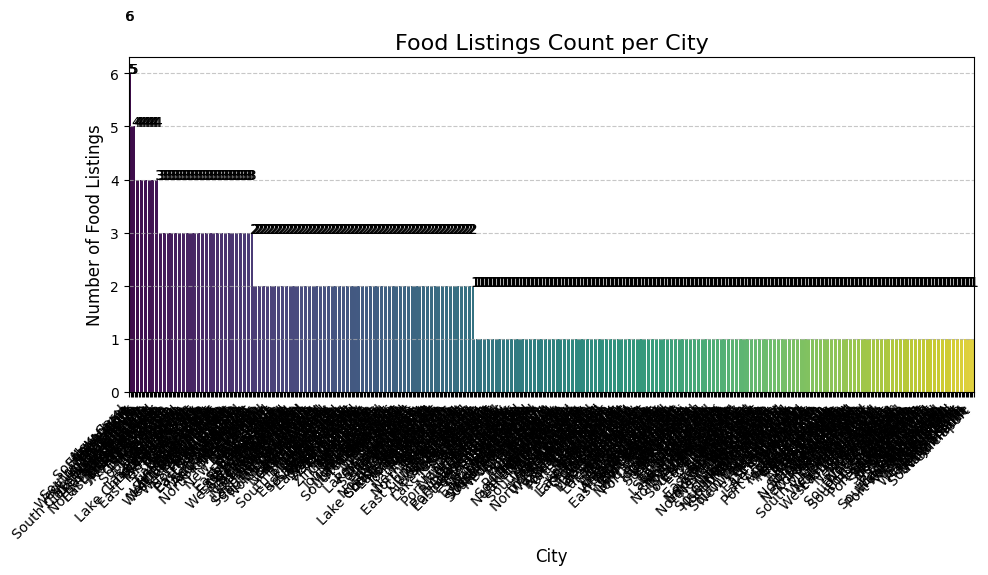

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

# Header
st.header("🍽️ Food Listings Distribution by City")

# Calculate counts
city_counts = food_listings['Location'].value_counts().reset_index()
city_counts.columns = ['City', 'Count']

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot using City as x and Count as y
sns.barplot(data=city_counts, x='City', y='Count', ax=ax, palette='viridis')

# Rotate x labels
plt.xticks(rotation=45, ha='right')

# Titles and labels
ax.set_title("Food Listings Count per City", fontsize=16)
ax.set_xlabel("City", fontsize=12)
ax.set_ylabel("Number of Food Listings", fontsize=12)

# Value labels on bars
for i, row in city_counts.iterrows():
    ax.text(i, row['Count'] + 1, str(row['Count']), color='black', ha='center', fontsize=10)

# Gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Layout adjustment
plt.tight_layout()

# Show plot in Streamlit
st.pyplot(fig)


In [20]:
st.sidebar.title("Add New Provider")
with st.sidebar.form(key='add_provider_form'):
    name = st.text_input("Provider Name")
    ptype = st.selectbox("Type", ["Restaurant", "Grocery Store", "Supermarket"])
    address = st.text_input("Address")
    city = st.text_input("City")
    contact = st.text_input("Contact")
    submit = st.form_submit_button("Add Provider")

if submit:
    cursor.execute('''
    INSERT INTO Providers (Name, Type, Address, City, Contact)
    VALUES (?, ?, ?, ?, ?)
    ''', (name, ptype, address, city, contact))
    conn.commit()
    st.success("Provider added successfully!")


2025-07-22 12:51:23.068 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:23.070 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:23.071 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:23.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:23.075 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:23.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:23.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:23.079 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [21]:
st.sidebar.header("Project Evaluation Tips")
st.sidebar.write("- Code quality: Modular functions & clear comments")
st.sidebar.write("- EDA insights integrated")
st.sidebar.write("- All queries executed and displayed")
st.sidebar.write("- CRUD implemented with form validation")
st.sidebar.write("- GitHub ReadMe with screenshots and explanations")
st.sidebar.write("- Proper presentation preparation before live eval")

2025-07-22 12:51:29.331 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:29.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:29.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:29.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:29.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:29.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:29.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:51:29.342 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [22]:
conn.close()
